# Calculate correlation functions with CCL
In this example, we will calculate clustering and lensing correlation functions for an example cosmology.

In [18]:
import numpy as np
import pylab as plt
import pyccl as ccl
%matplotlib inline

### Set up a Cosmology object
`Cosmology` objects contain the parameters and metadata needed as inputs to most functions. In `pyccl`, you can create one by first creating a new `Parameters` object, which simply contains the values of cosmological parameters (including some derived parameters). In this example, we define the parameters of a vanilla LCDM model, but simple extensions (like curvature, neutrino mass, and w0/wa) are also supported.

`Cosmology` objects contain precomputed data (e.g. splines) to help speed-up certain calculations. As such, `Cosmology` objects are supposed to be immutable; you should create a new `Cosmology` object when you want to change the values of any cosmological parameters.

In [19]:
p = ccl.Parameters(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96)
cosmo = ccl.Cosmology(p)

In [20]:
print p

Parameters
----------
        Omega_c: 0.27
        Omega_b: 0.045
        Omega_m: 0.315
        Omega_n: 0.0
        Omega_k: 0.0
             w0: -1.0
             wa: 0.0
             H0: 67.0
              h: 0.67
            A_s: 2.1e-09
            n_s: 0.96
        Omega_g: 5.51161385305e-05
          T_CMB: 2.726
        sigma_8: nan
        Omega_l: 0.684944883861
         z_star: nan
    has_mgrowth: False


As you can see, a number of cosmological parameters have been set to default values, or derived from the input parameters. Some, like `sigma_8`, have been left undefined; this is because calculating them from the input parameters is non-trivial, so this will only be done if needed (or if the user explicitly requests it).

### Define a source number density
The angular power spectrum is weighted by the source number density as a function of redshift, dN/dz. We define an example here.

In [21]:
z = np.linspace(0., 3., 200)
i_lim = 26. # Limiting i-band magnitude
z0 = 0.0417*i_lim - 0.744

Ngal = 46. * 100.31 * (i_lim - 25.) # Normalisation, galaxies/arcmin^2
pz = 1./(2.*z0) * (z / z0)**2. * np.exp(-z/z0) # Redshift distribution, p(z)
dNdz = Ngal * pz # Number density distribution

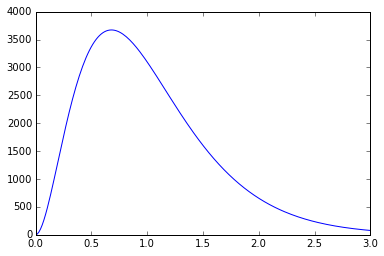

In [22]:
plt.plot(z, dNdz)
plt.show()

### Create ClTracer objects
CCL manages auto- and cross-spectrum calculations through `ClTracer` objects. For the sake of this example we will define two separate tracers, but both will effectively be the same tracer (so we end up calculating the auto-spectrum).

In [23]:
lens1 = ccl.ClTracerLensing(cosmo, False, z, dNdz)
lens2 = ccl.ClTracerLensing(cosmo, False, z, dNdz)

The argument set to `False` in these statements specifies that we are ignoring intrinsic alignments.
If we wanted to include intrinsic alignments, we could have created the `ClTracer` object in the following way:

In [24]:
bias_ia = -0.01* np.ones(z.size) # Intrinsic alignment bias factor
f_red = 0.2 * np.ones(z.size) # Fraction of red galaxies
lens1_ia = ccl.ClTracerLensing(cosmo, True, z, dNdz, z, bias_ia, z, f_red)

### Calculate the correlation functions
We can now calculate the correlation functions for the tracer(s). This will take some time. We are working on speed-ups for this computation. You can find more information in the CCL note. Notice that the last argument of the correlation function is the order of the bessel function in the integrand.

In [25]:
theta_rad = np.logspace(-1, np.log10(5.), 10)*np.pi/180. #note the input is in radians
lenscorrel_plus=ccl.correlation(theta_rad,cosmo,lens1,lens1,0)
lenscorrel_plus_ia=ccl.correlation(theta_rad,cosmo,lens1_ia,lens1_ia,0)
lenscorrel_minus=ccl.correlation(theta_rad,cosmo,lens2,lens2,4)

We can then plot the correlations:

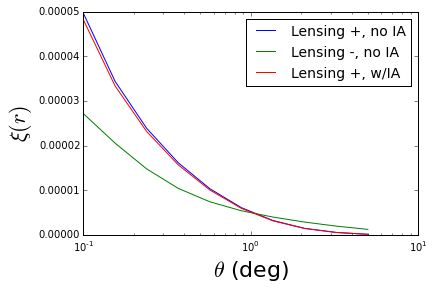

In [26]:
plt.plot(theta_rad*180/np.pi, lenscorrel_plus,label='Lensing +, no IA')
plt.plot(theta_rad*180/np.pi, lenscorrel_minus,label='Lensing -, no IA')
plt.plot(theta_rad*180/np.pi, lenscorrel_plus_ia,label='Lensing +, w/IA')
plt.gca().set_xscale('log')
plt.legend(loc='upper right',prop={'size':14})
plt.xlabel(r'$\theta$ (deg)',fontsize=22)
plt.ylabel(r'$\xi (r)$',fontsize=22)
plt.show()